# 不同策略的回测结果

除标记为`2019年数据`的数据外都是使用的历史数据（`2014-01-01`至`2018-12-31`）对不同的开仓和平仓策略进行的测试。所有策略中使用的参数均未做优化（也许是运气好得到了不错的结论，也有可能会有更优化的参数。但是会陷入过度优化陷阱）

从使用历史数据测试结果来看，所有策略的R值均小于`3`。`增加有持仓情况下2倍ATR时的加仓策略`的R值降低至`1.07`。说明这不是一个非常好的策略。

使用`2019年数据（2019-01-01~2019-12-31）`的测试结果也对其有了一定程度的验证。

仓位控制：采用凯利公式对仓位进行控制后，由于单次买入的数量增加（原本平均开仓费用为`1519.92`，现在为`2651.36`），资金利用率由`6.45%`提高至`11.41%`（依然较低），交易次数（5次，大幅低于[策略测试-通道策略-ATR波幅通道](策略测试-通道策略-ATR波幅通道.ipynb)的13次）。虽然因为仓位的增大带来了更高的亏损交易平均交易额（相对扩大51.02%），但是也正是因此而带来了更高的盈利交易平均盈利额（相对扩大105.40%）。从而造成总体由亏损变为盈利（考虑手续费后的情况）。

**本测试只说明了使用仓位控制比不使用仓位控制，会带来更好的收益。**

**但对于本策略来说，却说明了本策略并不是一个好的策略。**（应该是卖出时机点控制不好，造成了每笔亏损交易的亏损额较大）

**策略说明：**

- 买入：短期均线(10日)上穿长期均线(20日)
- 买入（加仓）：短期均线(10日)高于长期均线(20日)，并且收盘价超过现有持仓的当时买入价+2倍买入日ATR
- 卖出：长期均线(20日)下穿短期均线(10日)
- 卖出：持仓达到15日（以历史数据的亏损交易平均持仓时间为值），并且当日价格小于或等于现有持仓的当时买入价


|                                                                                        |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:---------------------------------------------------------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-均线策略-短期均线穿越长期均线（双均线）                                           |   6820.67  |   15611.4  |         27 |         15 |         12 |   0.555556 |             207.763  |              454.711 |            -100.922  | 2.06 |  -0.163974 |        2217.06 |
| 回测-均线策略-短期均线穿越长期均线（双均线）-增加最多持仓天数的卖出策略                |   6397.68  |   15127    |         27 |         11 |         16 |   0.407407 |             189.827  |              581.607 |             -79.5218 | 2.39 |  -0.163974 |        2217.06 |
| 回测-均线策略-短期均线穿越长期均线（双均线）-增加止损(1倍ATR）止盈（10倍ATR）          |   6820.67  |   15611.4  |         27 |         15 |         12 |   0.555556 |             207.763  |              454.711 |            -100.922  | 2.06 |  -0.163974 |        2217.06 |
| 回测-均线策略-短期均线穿越长期均线（双均线）-增加有持仓情况下2倍ATR时的加仓策略        |   8799.35  |   15947.3  |         41 |         20 |         21 |   0.487805 |             145.01   |              439.967 |            -135.902  | 1.07 |  -0.265648 |        2402.39 |
| 回测-均线策略-短期均线穿越长期均线（双均线）+最多持仓天数(2019年数据)                  |    370.287 |    9909.92 |          5 |          2 |          3 |   0.4      |             -14.3242 |              185.144 |            -147.303  | 0.1  |  -0.100755 |        1519.92 |
| 回测-均线策略-短期均线穿越长期均线（双均线）+最多持仓天数+凯利公式仓位控制(2019年数据) |    760.574 |   10061.7  |          5 |          2 |          3 |   0.4      |              18.7032 |              380.287 |            -222.353  | 0.08 |  -0.123031 |        2651.36 |

In [20]:
import gquant
import abupy
import QUANTAXIS as QA
import gquant.jupyter_helper
gquant.jupyter_helper.init()

# 原始数据

In [2]:
# 原始未复权数据
ori_data_df = gquant.pd.read_csv('300378_daily.csv', 
                                 encoding='utf-8', 
                                 parse_dates=[0], 
                                 dtype={'code': str}).set_index(['date', 'code'])
ori_data = QA.QAData.QA_DataStruct_Stock_day(ori_data_df)
# 前复权数据
ori_data_df_qfq = ori_data.to_qfq().data

# 数据初始化

In [3]:
class LocalDataAPI(abupy.MarketBu.ABuDataBase.StockBaseMarket,
                   abupy.MarketBu.ABuDataBase.SupportMixin):
    def _support_market(self):
        """声明数据源支持A股"""
        return [abupy.EMarketTargetType.E_MARKET_TARGET_CN]

    def kline(self, n_folds=2, start=None, end=None):
        df = ori_data_df_qfq.copy()
        df['pre_close'] = df['close'].shift()
        df['date'] = df.index.get_level_values(0)
        df['date'] = df['date'].dt.strftime('%Y%m%d').apply(
            lambda x: abupy.ABuDateUtil.date_str_to_int(x))
        df.index = df.index.droplevel(1)
        df.index.name = 'dt'
        df['date_week'] = df.index.dayofweek
        if start and end:
            return df[start:end]
        elif start:
            return df[start:]
        elif end:
            return df[:end]
        return df

    def minute(self, n_fold=5, *args, **kwargs):
        """分钟k线接口"""
        raise NotImplementedError('QAApi minute NotImplementedError!')

In [4]:
abupy.env.g_market_target = abupy.env.EMarketTargetType.E_MARKET_TARGET_CN
# 所有任务数据强制网络更新
abupy.env.g_data_fetch_mode = abupy.env.EMarketDataFetchMode.E_DATA_FETCH_FORCE_NET
# 使用QUATAXIS本地数据作为数据源
abupy.env.g_private_data_source = LocalDataAPI

In [5]:
# symbol = abupy.ABuMarket.code_to_symbol('sz300378')
# df = LocalDataAPI(symbol).kline()
# df

In [37]:
from abupy.IndicatorBu.ABuNDAtr import calc_atr
from QUANTAXIS.QAIndicator.talib_series import SMA


class KLManager(abupy.AbuKLManager):
    def _fetch_pick_time_kl_pd(self, target_symbol):
        data = abupy.MarketBu.ABuSymbolPd.make_kl_df(target_symbol,start=self.benchmark.start,end=self.benchmark.end)
        if not data.empty:
            high = data['high']
            low = data['low']
            pre_close = data['pre_close']
            data['atr14'] = calc_atr(high, low, pre_close, 14)
            data['atr21'] = calc_atr(high, low, pre_close, 21)
            data['atr'] = calc_atr(high, low, pre_close, 20)
            for ma in [10,20]:
                data['ma{}'.format(ma)] = SMA(data.close,timeperiod=ma)
            # 短期均线(10日)上穿长期均线(20日)
            data['buy']=QA.QAIndicator.CROSS(data['ma10'],data['ma20'])
            # 长期均线(20日)上穿短期均线(10日)（卖出）
            data['sell']=QA.QAIndicator.CROSS(data['ma20'],data['ma10'])
        result = data[self.benchmark.start:self.benchmark.end]
        result.name = data.name
        return result

## 初始化数据读取示例

In [7]:
# 沪深300指数
benchmark=gquant.abupy.TradeBu.ABuBenchmark.AbuBenchmark(benchmark='000300', start='2014-01-01', end='2019-12-31')
# 资金管理。使用默认的手续费计算方法
capital=gquant.abupy.TradeBu.ABuCapital.AbuCapital(10000,benchmark,)

In [8]:
# abupy.MarketBu.ABuSymbolPd.make_kl_df('300378')

# 简单测试

**问题**： 所有简单测试都并不准确，仅做示例参考。因为：

1. 以当日收盘价作为判断依据的同时，以当日作为建仓或清仓标准是不合理的。
2. 没有考虑交易手续费

In [9]:
def simple_test(data,**kwargs):
    """
    
    Args:
        cols1 (list): 第一个y轴的标签集合。默认为`['close']`。
        cols2 (list): 第二个y轴的标签集合。默认为`[]`。第二个轴会显示为虚线。
    """
    fig, ax1 = gquant.plt.subplots()
    # 绘制完整布林带买卖盈亏示例
    data[kwargs.pop('cols1',['close'])].plot(figsize=(50,10),ax=ax1)
    if 'buy' in data:
        ax1.vlines(data[data['buy'] == 1].index,0,data[data['buy'] == 1]['close'].max(),colors='r', linestyle=':')
    if 'sell' in data:
        ax1.vlines(data[data['sell'] == 1].index,0,data[data['buy'] == 1]['close'].max(), colors='g',linestyle=':')
    simple_profit=[]#盈亏示例
    record=[]#成交明细
    if 'buy' in data and 'sell' in data:
        last_buy=[]
        for index,row in data.iterrows():
            if row['buy']==1:
                last_buy.append(index)
                continue
            if row['sell']==1:
                while last_buy:
                    b=last_buy.pop(0)
                    buy_close=data['close'][b]
                    sell_close=data['close'][index]
                    record.append(gquant.pd.DataFrame(
                    {
                        'bd':[b],#买入日期
                        'bp':[buy_close],#买入价格
                        'sd':[index],#卖出日期
                        'sp':[sell_close],#卖出价格
                        'h':[len(data['close'][b:index])],#持仓天数
                        'sc':[100]#模拟买入100股
                    }))
                    pf=(sell_close-buy_close)/buy_close#交易盈亏率
                    data.loc[b:index,'close'].plot.area(ax=ax1,color='g' if sell_close<=buy_close else 'r', alpha=0.5)
                    ax1.annotate('{:.2f}'.format(pf),(b,buy_close), fontsize=16)
                    simple_profit.append(pf)
        record=gquant.pd.concat(record)
        record['profit']=record.apply(lambda x:(x.sp-x.bp)*x.sc,axis=1)
    cols2=kwargs.pop('cols2',[])
    if cols2:
        ax2 = ax1.twinx()
        data[cols2].plot(ax=ax2,ls='--')
        ax2.tick_params(axis='y')
    fig.tight_layout()
    gquant.plt.show()
    
    if simple_profit:
        # 绘制单次盈亏比率柱状图
        simple_profit=gquant.pd.Series(simple_profit)
        simple_profit.round(2).sort_index().plot(kind='bar',figsize=(5,3),title='单次盈亏比率')
        gquant.plt.show()
    
        # 绘制盈亏占比饼图
        gquant.pd.Series(gquant.np.sign(simple_profit)).value_counts().plot(kind='pie', autopct='%1.1f%%',figsize=(5,3),title='盈亏次数占比')
        gquant.plt.show()
        
        s= gquant.pd.Series(
            {
                '盈利交易平均盈利比率':simple_profit[simple_profit > 0].mean(),
                '最大盈利比率':simple_profit.max(),
                '亏损交易平均亏损比率':simple_profit[simple_profit <= 0].mean(),
                '最大亏损比率':simple_profit.min(),
                '平均盈亏比率':simple_profit.mean(),
                '交易次数':simple_profit.count(),
                '总天数':len(data),
                '平均持仓天数':record['h'].mean(),
                'R(平均利润/平均损失)':abs(record['profit'].mean()) / abs(record[record['profit']<=0]['profit'].mean())
            })
        return s
    return gquant.pd.Series()

## 短期均线穿越长期均线（双均线）

- 短期均线上穿长期均线（买入）
- 长期均线上穿短期均线（卖出）

* 短期均线：10日
* 长期均线：20日

测试了2014~2019年之间的数据。

|                                         |   盈利交易平均盈利比率 |   最大盈利比率 |   亏损交易平均亏损比率 |   最大亏损比率 |   平均盈亏比率 |   交易次数 |   总天数 |   平均持仓天数 |   R(平均利润/平均损失) |
|:----------------------------------------|-----------------------:|---------------:|-----------------------:|---------------:|---------------:|-----------:|---------:|---------------:|-----------------------:|
| 简单测试-短期均线穿越长期均线（双均线） |               0.197792 |         0.8529 |             -0.0469693 |      -0.109115 |      0.0642859 |         33 |     1442 |        20.8485 |                2.25487 |

问题：[简单测试的问题说明](#%E7%AE%80%E5%8D%95%E6%B5%8B%E8%AF%95)

In [10]:
simple_data=KLManager(benchmark,capital).get_pick_time_kl_pd('300378')
# 收盘价上穿布林带上轨
simple_data['buy']=QA.QAIndicator.CROSS(simple_data['ma10'],simple_data['ma20'])
# 收盘价下穿布林带中轨
simple_data['sell']=QA.QAIndicator.CROSS(simple_data['ma20'],simple_data['ma10'])

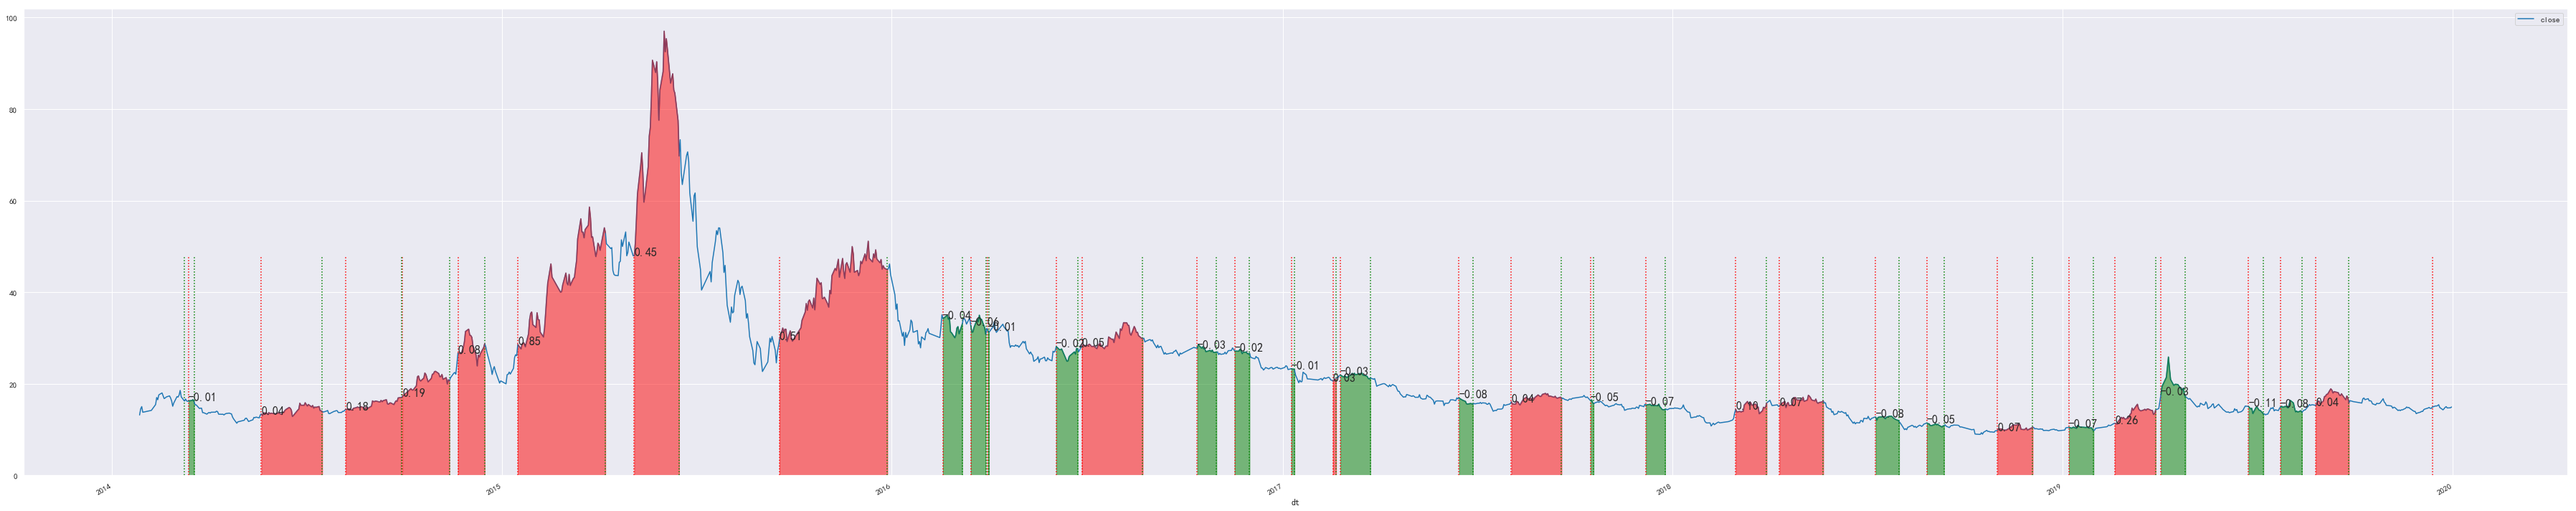

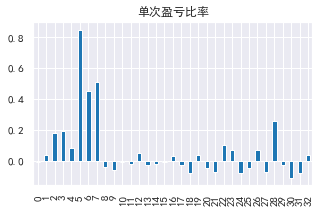

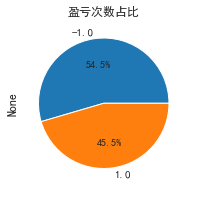

In [11]:
st1=simple_test(simple_data)

In [12]:
st1.name="简单测试-短期均线穿越长期均线（双均线）"
print(st1.to_frame().T.to_markdown())

|                                         |   盈利交易平均盈利比率 |   最大盈利比率 |   亏损交易平均亏损比率 |   最大亏损比率 |   平均盈亏比率 |   交易次数 |   总天数 |   平均持仓天数 |   R(平均利润/平均损失) |
|:----------------------------------------|-----------------------:|---------------:|-----------------------:|---------------:|---------------:|-----------:|---------:|---------------:|-----------------------:|
| 简单测试-短期均线穿越长期均线（双均线） |               0.197792 |         0.8529 |             -0.0469693 |      -0.109115 |      0.0642859 |         33 |     1442 |        20.8485 |                2.25487 |


# 训练回测

## 仓位控制方法

In [13]:
class Position1(abupy.AbuPositionBase):
    """1手"""
    def _init_self(self, **kwargs):
        """子类仓位管理针对可扩展参数的初始化"""
        pass

    def fit_position(self, factor_object):
        return 100

## 回测方法

In [57]:
def backtest(buy_factors,sell_factors,init_cash=10000,**kwargs):
    start = kwargs.pop('start','2014-01-01')
    end = kwargs.pop('end','2018-12-31')

    benchmark = abupy.AbuBenchmark('000300', start, end)
    # import pdb
    # pdb.set_trace()
    capital = abupy.AbuCapital(init_cash, benchmark)
    klmanager=kwargs.pop('klmanager',KLManager)
    orders_pd, action_pd, _ = abupy.ABuPickTimeExecute.do_symbols_with_same_factors(
        ['300378'],
        benchmark,
        buy_factors,
        sell_factors,
        capital,
        kl_pd_manager=klmanager(benchmark, capital),
        show=kwargs.pop('show',False))
    m = gquant.Metrics(orders_pd, action_pd, capital, benchmark)
    m.fit_metrics()
    if hasattr(m, 'act_sell') and not m.act_sell.empty:
        m.act_sell['profit_init']=m.act_sell['profit'] / m.capital.read_cash
        m.act_sell['profit_init_hunder'] = m.act_sell['profit_init'] * 100
        return m
    return None

## 回测结果绘图

In [15]:
def plot_cum_returns(metrics):
    metrics.benchmark_cum_returns.plot()
    metrics.algorithm_cum_returns.plot()
    gquant.plt.legend(['基准收益', '策略收益'], loc='best')
    gquant.plt.title('收益对比')
    gquant.plt.show()

def plot_win_loss_pie(metrics):
    gquant.plt.pie(x=[len(metrics.ret), len(metrics.los)],
                   labels=['盈利', '亏损'],
                   colors=['#d62728', '#2ca02c'],
                   autopct='%1.2f%%')
    gquant.plt.title('盈亏次数比')
    gquant.plt.show()
    
def plot_win_loss_bar(metrics,v='profit_cg_hunder'):
    import matplotlib.ticker
    vc=gquant.np.round(metrics.act_sell[v],0).value_counts().sort_index().to_frame()
    ax=vc.plot(kind='bar',title='盈亏百分比次数')
#     gquant.plt.axvline(x=gquant.np.where(vc.index.to_numpy()==0)[0], color='#d68a27')
#     ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    gquant.plt.show()
    
def plot_capital_blance(metrics):
    metrics.capital.capital_pd.capital_blance.plot(title='账户价值曲线')
    metrics.capital.capital_pd.cash_blance .plot(title='账户现金曲线')
    gquant.plt.xticks(rotation=70)
    gquant.plt.show()

## 短期均线穿越长期均线（双均线）

- 短期均线(10日)上穿长期均线(20日)（买入）
- 长期均线(20日)上穿短期均线(10日)（卖出）
- 仓位控制：每次买入100股。（[Position1](#%E4%BB%93%E4%BD%8D%E6%8E%A7%E5%88%B6%E6%96%B9%E6%B3%95)）
- 总资金：10000元
- 回测时间段：2014-01-01 ~ 2018-12-31

|                                     |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-短期均线穿越长期均线（双均线） |    6820.67 |    15611.4 |         27 |         15 |         12 |   0.555556 |              207.763 |              454.711 |             -100.922 | 2.06 |  -0.163974 |        2217.06 |

### 买卖策略

In [16]:
class BuyStrategy1(gquant.abupy.AbuFactorBuyTD, gquant.abupy.BuyCallMixin):
    def _init_self(self, **kwargs):
        self.factor_name = self.__class__.__name__

    def fit_day(self, today):
        if today['buy']:
            return self.buy_tomorrow()
        return None
    
class SellStrategy1(gquant.abupy.AbuFactorSellBase):
    def _init_self(self, **kwargs):
        self.factor_name = self.__class__.__name__

    def support_direction(self):
        """支持的方向，只支持正向"""
        return [abupy.ESupportDirection.DIRECTION_CAll.value]

    def fit_day(self, today, orders):
        if today['sell']:
            for order in orders:
                self.sell_tomorrow(order)

In [17]:
# 买入因子
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {
            'class': Position1
        }
    },
]

# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
}]

bt1 = backtest(buy_factors,sell_factors)

Box(children=(Text(value='pid=8252 begin work'), FloatProgress(value=0.0)))

### 结果

In [18]:
print(bt1.profit_series(name='回测-均线策略-短期均线穿越长期均线（双均线）').to_frame().T.to_markdown())

|                                              |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:---------------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-均线策略-短期均线穿越长期均线（双均线） |    6820.67 |    15611.4 |         27 |         15 |         12 |   0.555556 |              207.763 |              454.711 |             -100.922 | 2.06 |  -0.163974 |        2217.06 |


### 结果绘图

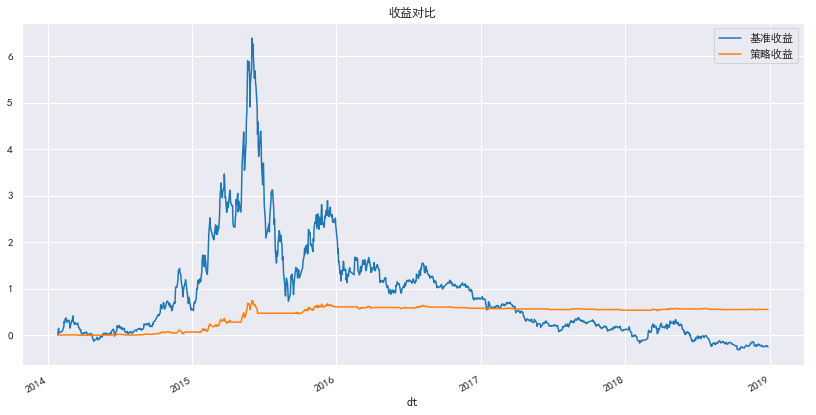

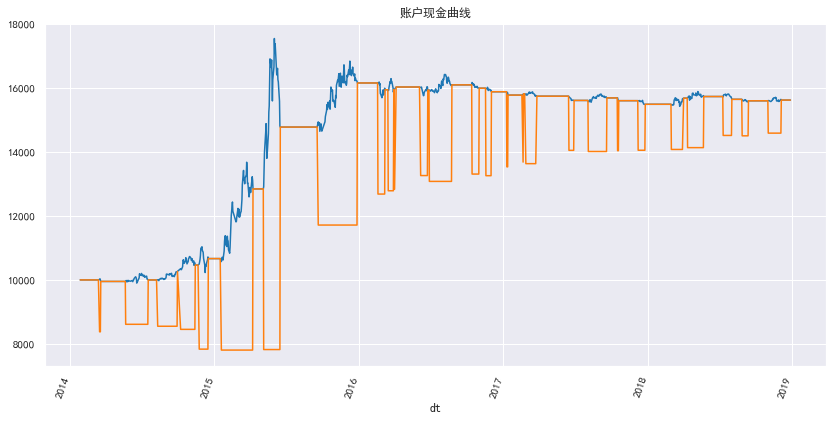

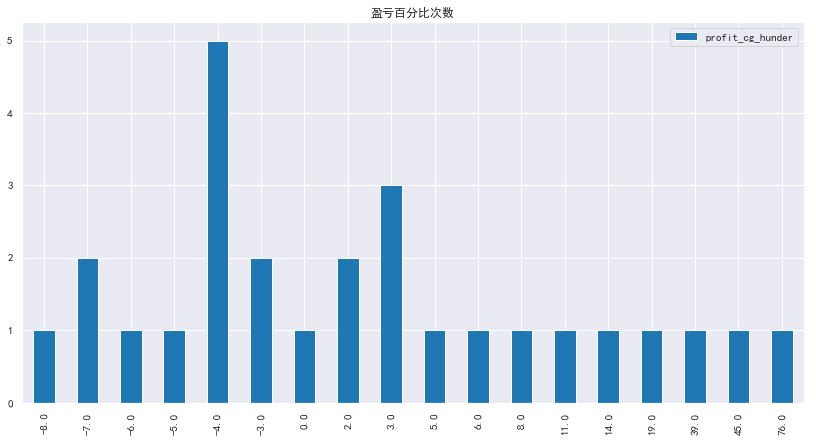

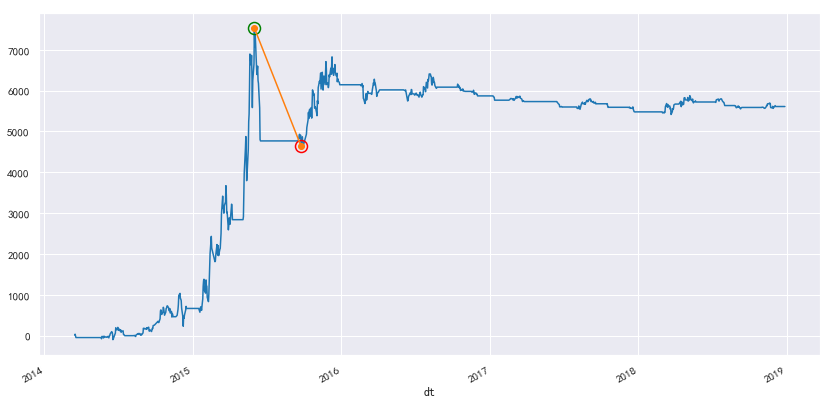

最大回撤: 0.165147
最大回测启始时间:2015-06-02, 结束时间2015-09-25, 共回测2895.355000
策略持股天数平均数: 29.259
策略持股天数中位数: 22.000


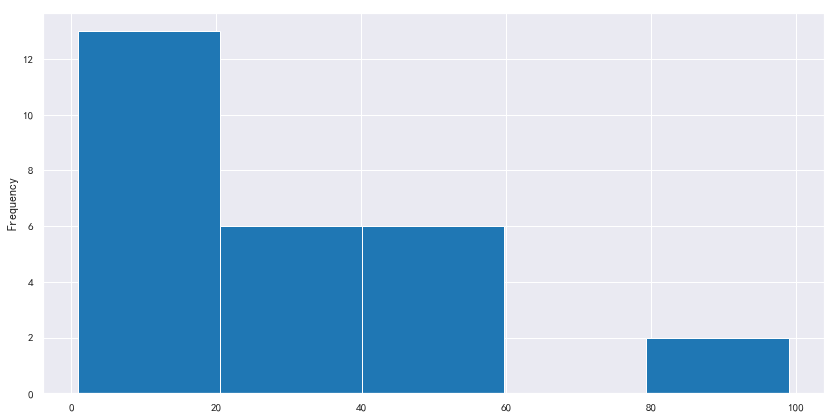

因子平均生效间隔:65.03846153846153


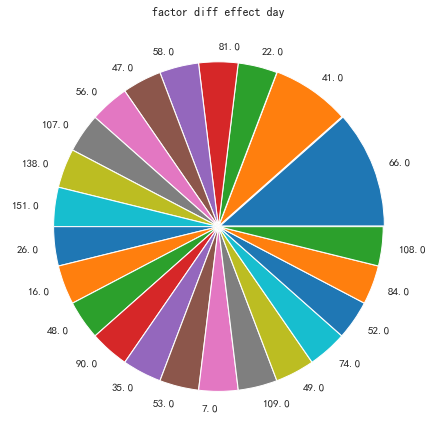

开仓花费情况: 
count:27
max:5005.700195822189
min:1003.4936553937769
mean:2217.0553970537726
std:896.3653453021952
skewness:0.9990004183878964
kurtosis:1.143740902916364


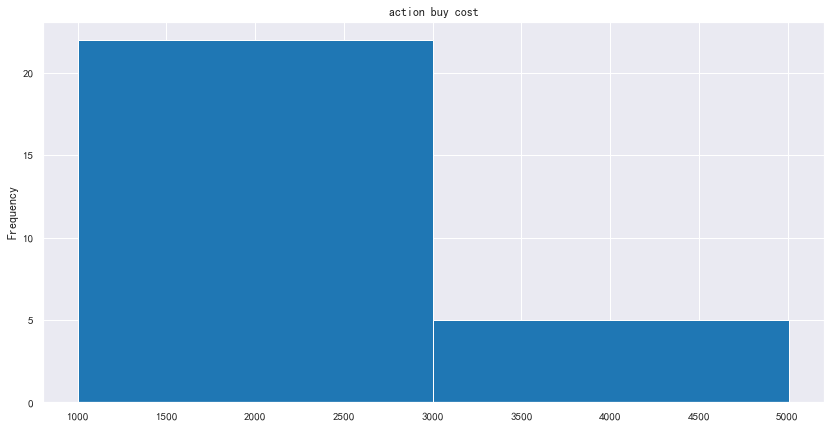

In [21]:
plot_cum_returns(bt1)
plot_capital_blance(bt1)
plot_win_loss_bar(bt1)
bt1.plot_max_draw_down()
bt1.plot_keep_days()
bt1.plot_effect_mean_day()
bt1.plot_action_buy_cost()

### 平均持仓天数

In [25]:
import logging
logging.info('盈利交易持仓时间')
logging.info(bt1.order_has_ret[bt1.order_has_ret.profit>0].keep_days.describe())
logging.info('亏损交易持仓时间')
logging.info(bt1.order_has_ret[bt1.order_has_ret.profit<=0].keep_days.describe())

盈利交易持仓时间
count    15.0000
mean     41.0667
std      26.3451
min       1.0000
25%      27.0000
50%      41.0000
75%      53.5000
max      99.0000
Name: keep_days, dtype: float64
亏损交易持仓时间
count    12.0000
mean     14.5000
std       7.9143
min       3.0000
25%      10.5000
50%      17.0000
75%      18.0000
max      28.0000
Name: keep_days, dtype: float64


## 增加最多持仓天数的卖出策略
### 卖出策略

In [32]:
class SellStrategy2(abupy.AbuFactorSellBase):
    """n日卖出策略。当N日后股价小于等于买入价时卖出。"""

    def _init_self(self, **kwargs):
        """kwargs中可以包含: 参数sell_n：代表买入后持有的天数，默认15天"""
        self.sell_n = kwargs.pop('sell_n', 15)
        self.sell_type_extra = '{}:sell_n={}'.format(self.__class__.__name__, self.sell_n)

    def support_direction(self):
        """因子支持两个方向"""
        return [abupy.ESupportDirection.DIRECTION_CAll.value]


    def fit_day(self, today, orders):
        for order in orders:
            # 将单子的持有天数进行增加
            order.keep_days += 1
            if order.keep_days >= self.sell_n and order.buy_price>=today.close:
                self.sell_tomorrow(order)

In [33]:
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {
            'class': Position1
        }
    }
]

# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
},
    {
    'class': SellStrategy2,
}]
bt2 = backtest(buy_factors, sell_factors)

Box(children=(Text(value='pid=8252 begin work'), FloatProgress(value=0.0)))

### 结果

以15日（亏损交易的平均持仓天数）为参数值。增加了此止损策略后，虽然盈利次数减少了，但是亏损交易的平均亏损额大幅下降（下降21.20%），但盈利交易平均盈利大幅增加（增加27.9%）。R值由2.06上涨至2.39。可能由于盈利比率下降较多（15%），造成了最终盈亏总额有所下降。但是个人认为还是一个不错的策略。

In [34]:
gquant.pd.concat([bt1.profit_series(name='回测-均线策略-短期均线穿越长期均线（双均线）'),
                  bt2.profit_series(name='回测-均线策略-短期均线穿越长期均线（双均线）-增加最多持仓天数的卖出策略')]
                ,axis=1).T

,盈亏总额,最终价值,交易次数,盈利次数,亏损次数,盈利比率,每笔交易平均盈亏额,盈利交易平均盈利额,亏损交易平均亏损额,R,最大回撤,买入平均花费
回测-均线策略-短期均线穿越长期均线（双均线）,6820.6670,15611.385,27.0,15.0,12.0,0.5556,207.7632,454.7111,-100.9217,2.06,-0.164,2217.0554
回测-均线策略-短期均线穿越长期均线（双均线）-增加最多持仓天数的卖出策略,6397.6784,15126.962,27.0,11.0,16.0,0.4074,189.8270,581.6071,-79.5218,2.39,-0.164,2217.0554


买入后卖出的交易数量:27
买入后尚未卖出的交易数量:0
胜率:44.4444%
平均获利期望:18.0395%
平均亏损期望:-3.5499%
盈亏比:5.9337
策略收益: 51.3903%
基准收益: -25.6776%
策略年化收益: 10.8100%
基准年化收益: -5.4013%
策略买入成交比例:100.0000%
策略资金利用率比例:8.2724%
策略共执行1198个交易日


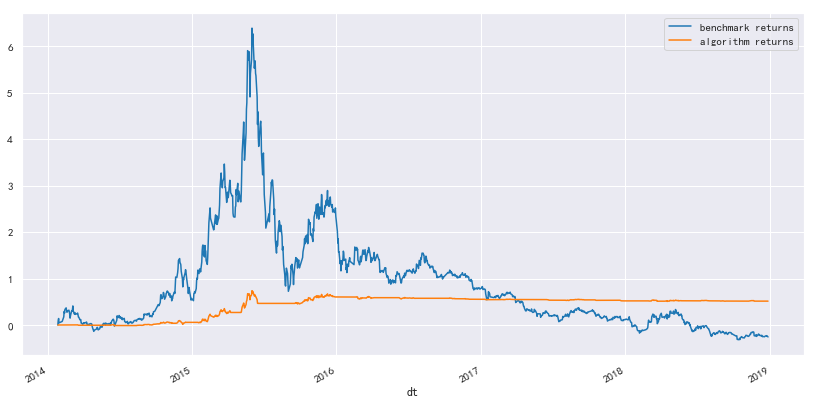

In [43]:
bt2.plot_returns_cmp(only_show_returns=True)

## 增加止损(1倍ATR）止盈（10倍ATR）

In [22]:
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {
            'class': Position1
        }
    }
]

# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
},
    {
    'class': abupy.AbuFactorAtrNStop,
    'stop_loss_n': 1,
    'stop_win_n': 10
}]
bt3 = backtest(buy_factors, sell_factors)

Box(children=(Text(value='pid=8252 begin work'), FloatProgress(value=0.0)))

### 结果

In [35]:
print(bt3.profit_series(name='回测-均线策略-短期均线穿越长期均线（双均线）-增加止损(1倍ATR）止盈（10倍ATR）').to_frame().T.to_markdown())

|                                                                               |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:------------------------------------------------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-均线策略-短期均线穿越长期均线（双均线）-增加止损(1倍ATR）止盈（10倍ATR） |    6820.67 |    15611.4 |         27 |         15 |         12 |   0.555556 |              207.763 |              454.711 |             -100.922 | 2.06 |  -0.163974 |        2217.06 |


In [36]:
gquant.pd.concat([bt1.profit_series(name='回测-均线策略-短期均线穿越长期均线（双均线）'),
                  bt2.profit_series(name='回测-均线策略-短期均线穿越长期均线（双均线）-增加最多持仓天数的卖出策略'),
                  bt3.profit_series(name='回测-均线策略-短期均线穿越长期均线（双均线）-增加止损(1倍ATR）止盈（10倍ATR）')]
                ,axis=1).T

,盈亏总额,最终价值,交易次数,盈利次数,亏损次数,盈利比率,每笔交易平均盈亏额,盈利交易平均盈利额,亏损交易平均亏损额,R,最大回撤,买入平均花费
回测-均线策略-短期均线穿越长期均线（双均线）,6820.6670,15611.385,27.0,15.0,12.0,0.5556,207.7632,454.7111,-100.9217,2.06,-0.164,2217.0554
回测-均线策略-短期均线穿越长期均线（双均线）-增加最多持仓天数的卖出策略,6397.6784,15126.962,27.0,11.0,16.0,0.4074,189.8270,581.6071,-79.5218,2.39,-0.164,2217.0554
回测-均线策略-短期均线穿越长期均线（双均线）-增加止损(1倍ATR）止盈（10倍ATR）,6820.6670,15611.385,27.0,15.0,12.0,0.5556,207.7632,454.7111,-100.9217,2.06,-0.164,2217.0554


## 增加有持仓情况下2倍ATR时的加仓策略

因为有1倍ATR止损的存在，所以可以考虑在2倍ATR时加仓（让利润奔跑。当当前股价超过购买时股价2倍ATR时，当时的仓位就已经是安全的了）。

### 买入策略（加仓）

In [38]:
class BuyStrategy2(gquant.abupy.AbuFactorBuyTD, gquant.abupy.BuyCallMixin):
    def _init_self(self, **kwargs):
        self.factor_name = self.__class__.__name__

    def fit_day(self, today):
        if self.orders:
            o=self.orders[-1]
            if o.sell_date is None:
                buy=self.kl_pd[self.kl_pd['date']==o.buy_date]#最后一次购买当日的信息
                atr=buy.iloc[0]['atr']#最后一次购买当日的atr数据
                if today.ma10>today.ma20 and today.close>o.buy_price+2*atr:
                    #当当日的短期均线（MA10）在长期均线（MA20）之上，并且当天收盘价大于最后一次购买价格+2倍购买日atr（可加仓价）
                    return self.buy_tomorrow()

In [49]:
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {
            'class': Position1
        }
    },
    {
        'class':BuyStrategy2,
        # 仓位管理
        'position': {
            'class': Position1
        }
    }
]
# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
}]
bt4= backtest(buy_factors,sell_factors)

Box(children=(Text(value='pid=8252 begin work'), FloatProgress(value=0.0)))

### 结果

因为增加了加仓操作，所以交易次数增加，同时会有部分建仓动作建立在了山顶上，造成盈亏比率下降。并且因为同样的原因（买在山顶上）造成亏损交易的平均亏损额大幅增加（增加35%）、最大回撤由16.40%增大到26.56%。从而造成了R值由`2.06`大幅降低至`1.07`。

In [50]:
gquant.pd.concat([bt1.profit_series(name='回测-均线策略-短期均线穿越长期均线（双均线）'),
                  bt2.profit_series(name='回测-均线策略-短期均线穿越长期均线（双均线）-增加最多持仓天数的卖出策略'),
                  bt3.profit_series(name='回测-均线策略-短期均线穿越长期均线（双均线）-增加止损(1倍ATR）止盈（10倍ATR）'),
                  bt4.profit_series(name='回测-均线策略-短期均线穿越长期均线（双均线）-增加有持仓情况下2倍ATR时的加仓策略')], axis=1).T

,盈亏总额,最终价值,交易次数,盈利次数,亏损次数,盈利比率,每笔交易平均盈亏额,盈利交易平均盈利额,亏损交易平均亏损额,R,最大回撤,买入平均花费
回测-均线策略-短期均线穿越长期均线（双均线）,6820.6670,15611.385,27.0,15.0,12.0,0.5556,207.7632,454.7111,-100.9217,2.06,-0.1640,2217.0554
回测-均线策略-短期均线穿越长期均线（双均线）-增加最多持仓天数的卖出策略,6397.6784,15126.962,27.0,11.0,16.0,0.4074,189.8270,581.6071,-79.5218,2.39,-0.1640,2217.0554
回测-均线策略-短期均线穿越长期均线（双均线）-增加止损(1倍ATR）止盈（10倍ATR）,6820.6670,15611.385,27.0,15.0,12.0,0.5556,207.7632,454.7111,-100.9217,2.06,-0.1640,2217.0554
回测-均线策略-短期均线穿越长期均线（双均线）-增加有持仓情况下2倍ATR时的加仓策略,8799.3492,15947.344,41.0,20.0,21.0,0.4878,145.0101,439.9675,-135.9016,1.07,-0.2656,2402.3918


# 测试回测

2019年数据

In [54]:
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {
            'class': Position1
        }
    }
]

# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
},
    {
    'class': SellStrategy2,
}]
bt_2019 = backtest(buy_factors, sell_factors,start='2019-01-01',end='2019-12-31')

Box(children=(Text(value='pid=8252 begin work'), FloatProgress(value=0.0)))

## 结果

In [55]:
print(gquant.pd.concat([bt1.profit_series(name='回测-均线策略-短期均线穿越长期均线（双均线）'),
                  bt2.profit_series(name='回测-均线策略-短期均线穿越长期均线（双均线）-增加最多持仓天数的卖出策略'),
                  bt3.profit_series(name='回测-均线策略-短期均线穿越长期均线（双均线）-增加止损(1倍ATR）止盈（10倍ATR）'),
                  bt4.profit_series(name='回测-均线策略-短期均线穿越长期均线（双均线）-增加有持仓情况下2倍ATR时的加仓策略'),
                  bt_2019.profit_series(name='回测-均线策略-短期均线穿越长期均线（双均线）+最多持仓天数(2019年数据)')], axis=1).T.to_markdown())

|                                                                                 |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:--------------------------------------------------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-均线策略-短期均线穿越长期均线（双均线）                                    |   6820.67  |   15611.4  |         27 |         15 |         12 |   0.555556 |             207.763  |              454.711 |            -100.922  | 2.06 |  -0.163974 |        2217.06 |
| 回测-均线策略-短期均线穿越长期均线（双均线）-增加最多持仓天数的卖出策略         |   6397.68  |   15127    |         27 |         11 |         16 |   0.407407 |             189.827  |              581.607 |             -79.5218 | 2.39 |  -0.163974 |        2217.06 |
| 回测-均线策略-短期均线穿越长期均线（双均线）-增加止损(1倍ATR）止盈（10倍A

## 使用凯利公式对仓位进行管理

根据[回测-均线策略-短期均线穿越长期均线（双均线）-增加最多持仓天数的卖出策略](#%E5%A2%9E%E5%8A%A0%E6%9C%80%E5%A4%9A%E6%8C%81%E4%BB%93%E5%A4%A9%E6%95%B0%E7%9A%84%E5%8D%96%E5%87%BA%E7%AD%96%E7%95%A5)

- 胜率:44.44%
- 平均获利期望:18.04%
- 平均亏损期望:-3.55%

In [59]:
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {'class': abupy.AbuKellyPosition, 'win_rate': bt2.win_rate, 
                                        'gains_mean': bt2.gains_mean, 'losses_mean': -bt2.losses_mean}
    }
]
# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
},
    {
    'class': SellStrategy2,
}
]
bt_2019_kelly = backtest(buy_factors, sell_factors,start='2019-01-01',end='2019-12-31')

Box(children=(Text(value='pid=8252 begin work'), FloatProgress(value=0.0)))

### 结果

In [60]:
print(gquant.pd.concat([bt1.profit_series(name='回测-均线策略-短期均线穿越长期均线（双均线）'),
                  bt2.profit_series(name='回测-均线策略-短期均线穿越长期均线（双均线）-增加最多持仓天数的卖出策略'),
                  bt3.profit_series(name='回测-均线策略-短期均线穿越长期均线（双均线）-增加止损(1倍ATR）止盈（10倍ATR）'),
                  bt4.profit_series(name='回测-均线策略-短期均线穿越长期均线（双均线）-增加有持仓情况下2倍ATR时的加仓策略'),
                  bt_2019.profit_series(name='回测-均线策略-短期均线穿越长期均线（双均线）+最多持仓天数(2019年数据)'),
                  bt_2019_kelly.profit_series(name='回测-均线策略-短期均线穿越长期均线（双均线）+最多持仓天数+凯利公式仓位控制(2019年数据)')], axis=1).T.to_markdown())

|                                                                                        |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:---------------------------------------------------------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-均线策略-短期均线穿越长期均线（双均线）                                           |   6820.67  |   15611.4  |         27 |         15 |         12 |   0.555556 |             207.763  |              454.711 |            -100.922  | 2.06 |  -0.163974 |        2217.06 |
| 回测-均线策略-短期均线穿越长期均线（双均线）-增加最多持仓天数的卖出策略                |   6397.68  |   15127    |         27 |         11 |         16 |   0.407407 |             189.827  |              581.607 |             -79.5218 | 2.39 |  -0.163974 |        2217.06 |
| 回测-均线策略-短期均线穿越

买入后卖出的交易数量:5
买入后尚未卖出的交易数量:1
胜率:40.0000%
平均获利期望:16.8143%
平均亏损期望:-8.2024%
盈亏比:1.2395
策略收益: 0.6111%
基准收益: 51.3113%
策略年化收益: 0.6311%
基准年化收益: 52.9937%
策略买入成交比例:100.0000%
策略资金利用率比例:11.4102%
策略共执行244个交易日


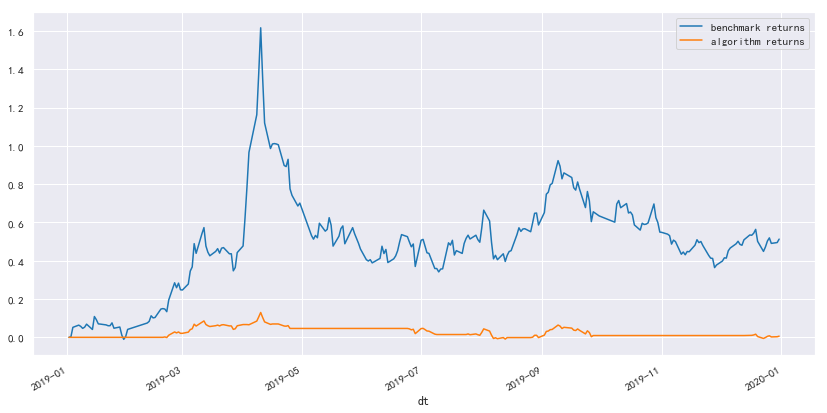

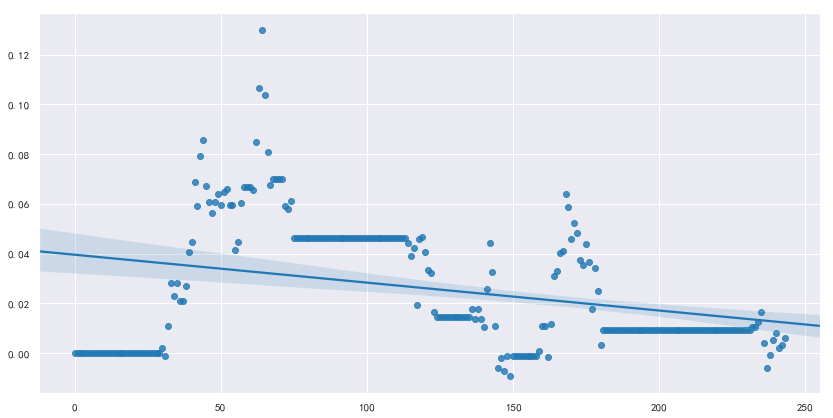

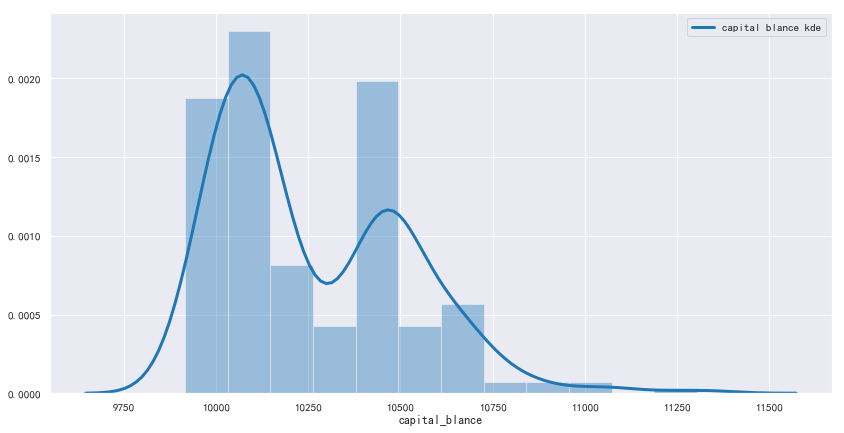

In [61]:
bt_2019_kelly.plot_returns_cmp()

买入后卖出的交易数量:5
买入后尚未卖出的交易数量:1
胜率:40.0000%
平均获利期望:16.8143%
平均亏损期望:-8.2024%
盈亏比:0.9583
策略收益: -0.5594%
基准收益: 51.3113%
策略年化收益: -0.5777%
基准年化收益: 52.9937%
策略买入成交比例:100.0000%
策略资金利用率比例:6.4453%
策略共执行244个交易日


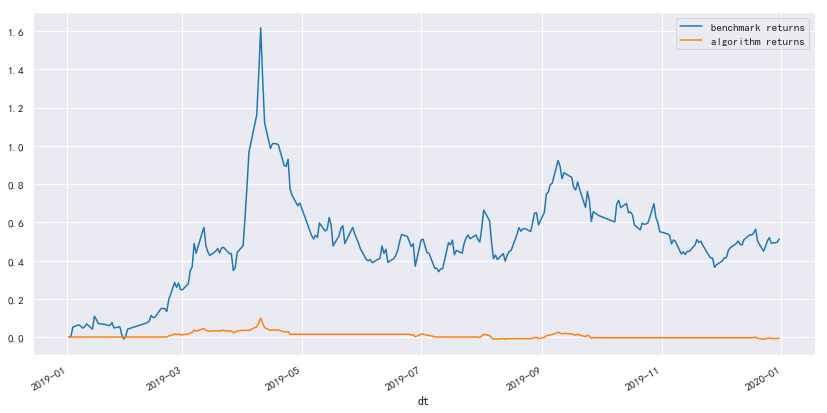

In [63]:
bt_2019.plot_returns_cmp(only_show_returns=True)

买入后卖出的交易数量:5
买入后尚未卖出的交易数量:1
胜率:40.0000%
平均获利期望:16.8143%
平均亏损期望:-8.2024%
盈亏比:1.2395
策略收益: 0.6111%
基准收益: 51.3113%
策略年化收益: 0.6311%
基准年化收益: 52.9937%
策略买入成交比例:100.0000%
策略资金利用率比例:11.4102%
策略共执行244个交易日


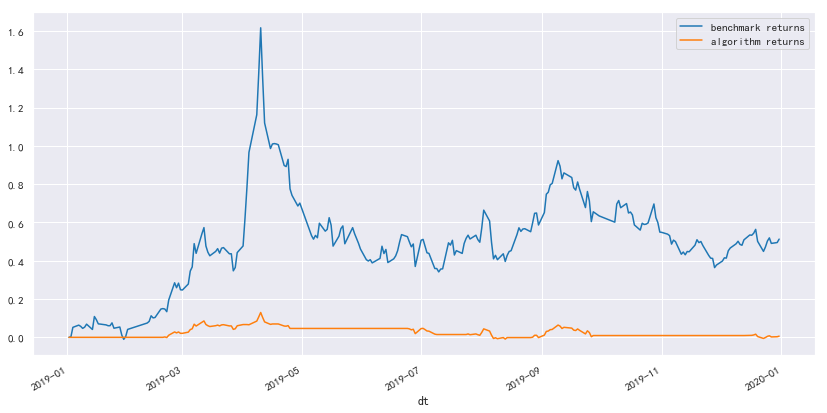

In [64]:
bt_2019_kelly.plot_returns_cmp(only_show_returns=True)